# Foreword

The objective of this script is to generate the economic exposure layer for Madagascar. The economic exposure layer is separated into two sublayers:
- **Building footprint sublayer**: The geolocalized polygons of building footprints for the entire country are downloaded from Google Open Buildings, each building having as attribute a value in dollars. To compute the value per building, the 5x5 km equispaced points from GAR15 Global Exposure Layer for Madagascar are used. First, it is assigned to each building the closest GAR15 point. Subsequently, the total value (attribute *tot_val*) per GAR15 point is disagregated across the building footprint area, obtaining an economic exposure value in dollars per m2. Therefore, the value per m2 is the same for all the buildings associated to the same point. Finally, the value in dollars per building is computed as the product of its value per m2 and the building footprint area.
- **Public infrastructure sublayer**: GAR15 does not include the value corresponding to public infrastructure. However, such assets are very relevant to perform an adequate flood risk assessment, as their partial or total damage can compromise the activity continuity, it being transportation, education, healthcare, administration, etc. To complement the *building footprint sublayer*, a geolocalized public infrastructure inventory is retrieved from OpenStreetMap.

**Sources**:

- **Google Open Buildings**: https://sites.research.google/gr/open-buildings/
- **GAR15 Global Exposure Dataset**: https://hgl.harvard.edu/catalog/stanford-zh363fy4461
- **OpenStreetMap**: https://wiki.openstreetmap.org/wiki/Map_features, https://download.geofabrik.de/africa/madagascar.html
- **GADM**: https://gadm.org/


# Methodology

In [1]:
from IPython.display import Image, display

image_path = '/Users/aprida/Documents/Consulting/Public_sector/GRMA_Madagascar/exposure/flowchart_economic_exposure.png'  # Display flow chart of project methodology
display(Image(filename=image_path))

# Import packages

In [2]:
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Polygon, shape
import os
from shapely import wkt, wkb
import duckdb
import numpy as np
import math
import quackosm
from gadm import GADMDownloader

In [3]:
root = '/Users/aprida/Documents/Consulting/Public_sector/GRMA_Madagascar/exposure' # Path to local working directory 

In [4]:
# Create a DuckDB database in memory
con = duckdb.connect()
# con.sql("INSTALL spatial;")
con.sql("LOAD spatial;") # Load Spatial extension

# Building footprints

Steps:

1. Identify Google Open Building tiles that intersect the polygon of Madagascar, extracted form GADM API (26 seconds).
2. Download .zip building footrpint files of intersected tiles and decompress into .csv files (44 seconds).
3. Merge .csv files of building footrpints into a single .parquet file (35 seconds).
4. Create GeoDataFrame from .parquet file (37 seconds).
5. Disaggregate GAR15 economic exposure on building footprints (1 minute 52 seconds).
6. Save building footprints (polygons) with economic exposure as attribute to .gpkg files (50 minutes).


## Inputs

In [4]:
# Path to aoi file or country name to call GADM API geometries
# fn_aoi = f'{root}/adm/mdg_admbnda_adm4_BNGRC_OCHA_20181031.shp' # Path to vector file of Madagascar
country_name = 'Madagascar'

# Read Google Building Tiles
url_tiles = 'https://openbuildings-public-dot-gweb-research.uw.r.appspot.com/public/tiles.geojson'

# URL to vector file of GAR15 Global Exposure Layer (alternatively, download file from website provided above)
fn_gar15 = 'https://stacks.stanford.edu/file/druid:zh363fy4461/data.zip' 

## Read AOI

In [87]:
# Download Madagascar polygon from GADM API
downloader = GADMDownloader(version='4.0')
ad_level = 0
gdf_aoi = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)
gdf_aoi = gdf_aoi[['geometry']]

# Alternatively, read on-the-shelf AOI polygon
# gdf_aoi = gpd.read_file(fn_aoi)
# gdf_aoi = gdf_aoi[['geometry']]
# gdf_aoi = gdf_aoi.to_crs(4326)
# gdf_aoi = gdf_aoi.iloc[[1]]

## Identify Google Buildings polygons within AOI

Text(297.4500140508738, 0.5, 'Latitude (degrees)')

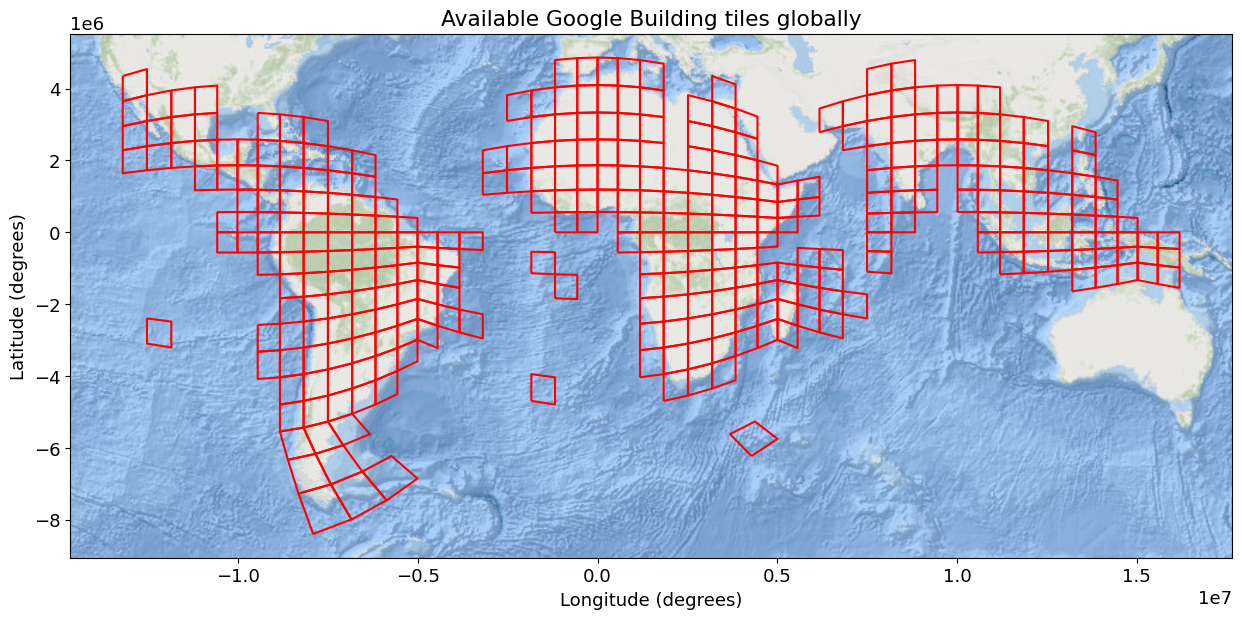

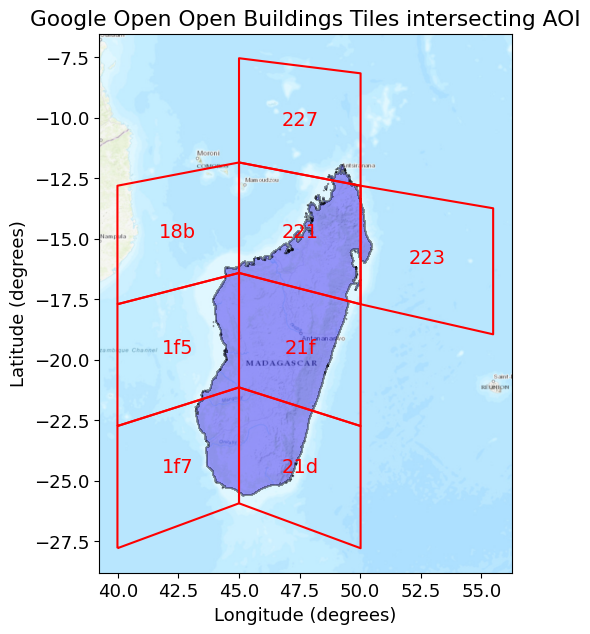

In [89]:
# Read Google Building Tiles
response = requests.get(url_tiles)
geojson_data = response.json()
gdf_tiles = gpd.GeoDataFrame.from_features(geojson_data['features'], crs=4326)

# Plot Google Open Buildings available tiles at global scale
plt.rcParams['font.size'] = 13
fig, ax = plt.subplots(figsize=(15,10))
gdf_tiles.to_crs(3857).boundary.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, source=cx.providers.Esri.OceanBasemap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('Available Google Building tiles globally')

# Identify tiles intersecting AOI
gdf_aoi_tiles = gpd.sjoin(gdf_tiles, gdf_aoi, predicate='intersects').reset_index(drop=True)

# Plot selected tiles and AOI
fig, ax = plt.subplots(figsize=(11,7))
gdf_aoi_tiles.boundary.plot(ax=ax, color='red')

# Add labels in the center of each tile
for idx, row in gdf_aoi_tiles.iterrows():
    # Get the centroid of the tile polygon
    centroid = row['geometry'].centroid
    # Add the tile_id as text at the centroid position
    ax.text(centroid.x, centroid.y, row['tile_id'], ha='center', va='center', fontsize=14, color='red')
    ax.set_title('Google Open Open Buildings Tiles intersecting AOI')

gdf_aoi.plot(ax=ax, color='blue', edgecolor='black', alpha=0.4)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

In [232]:
# Download Google Buildings polygons zipfiles for tiles intersecting the AOI and decompress (one .csv file per tile)
dir_gob = f'{root}/gob' # Path to create directory in local to store Google Open Buildings files
os.makedirs(dir_gob, exist_ok=True) # Generate Google Open Buildings directory in local to store files

for index, row in gdf_aoi_tiles.drop_duplicates(subset='tile_url').iterrows():
    # Download building file
    compressed_path = f'{dir_gob}/{row["tile_id"]}_buildings.csv.gz'
    decompressed_path = f'{dir_gob}/{row["tile_id"]}_buildings.csv'
    tile_path = row['tile_url']
    os.system(f'wget -O {compressed_path} {tile_path}') # Download zip file to local (faster than scrapping the data from url)
    # Decompress the file
    os.system(f'gunzip -c {compressed_path} > {decompressed_path}') # Unzip file to .csv
    

--2024-11-25 17:35:01--  https://storage.googleapis.com/open-buildings-data/v3/polygons_s2_level_4_gzip/18b_buildings.csv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4007:80e::201b, 2a00:1450:4007:807::201b, 2a00:1450:4007:80b::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4007:80e::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70871435 (68M) [application/octet-stream]
Saving to: ‘/Users/aprida/Documents/Consulting/Public_sector/GRMA_Madagascar/exposure/gob/18b_buildings.csv.gz’

     0K .......... .......... .......... .......... ..........  0% 1,68M 40s
    50K .......... .......... .......... .......... ..........  0% 1,88M 38s
   100K .......... .......... .......... .......... ..........  0% 3,19M 32s
   150K .......... .......... .......... .......... ..........  0% 1,87M 33s
   200K .......... .......... .......... .......... ..........  0% 2,70M 32s
   250K .......... .......... .

In [45]:
# Merge efficiently building footprint files in a single file and save to parquet format using duckdb
dir_gob = f'{root}/gob'
merged_df = con.execute(f"""
    SELECT * 
    FROM read_csv_auto('{dir_gob}/*.csv')
""").fetch_df()

# Save the merged data to a new CSV file (optional)
fn = f'{root}/buildings_all.parquet'
merged_df.to_parquet(fn)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
# Read parquet file of buildings using duckdb
df_buildings = con.execute(f"""
    SELECT * FROM read_parquet('{fn}')
""").fetch_df() # Read parquet file of buildings using duckdb
# Generate geodataframe of buildings (centroids - points)
df_buildings.rename(columns={'geometry': 'geom_pol'}, inplace=True)
gdf_buildings = gpd.GeoDataFrame(df_buildings, geometry=gpd.GeoSeries.from_xy(df_buildings['longitude'], df_buildings['latitude']), crs=4326)
# Add spatial indexes to layers to intersect
gdf_buildings.sindex
gdf_aoi.sindex
# Identify the buildings that intersect the AOI
gdf_buildings_aoi = gpd.sjoin(gdf_buildings, gdf_aoi)
gdf_buildings_aoi.drop(columns=['index_right'], inplace=True)

## Disaggregate GAR15 economic value per pixel

In [ ]:
# Read GAR15 layer
gdf_gar15 = gpd.read_file(fn_gar15)
gdf_gar15 = gdf_gar15[['id_5x', 'iso3', 'tot_val', 'geometry']]
# Assign spatial indexes to speed up spatial join
gdf_gar15.sindex
gdf_buildings_aoi.sindex
# Join attributes of GAR15 to buildings_aoi based on spatial nearest neighbor
gdf_buildings_aoi_gar15 = gpd.sjoin_nearest(gdf_buildings_aoi, gdf_gar15, distance_col='distance_deg')
gdf_buildings_aoi_gar15['total_area_gar_point'] = gdf_buildings_aoi_gar15.groupby('id_5x')['area_in_meters'].transform('sum')
gdf_buildings_aoi_gar15['value_m2'] = gdf_buildings_aoi_gar15['tot_val'] * 1e6 / gdf_buildings_aoi_gar15['total_area_gar_point']
gdf_buildings_aoi_gar15['value_dollar'] = gdf_buildings_aoi_gar15['value_m2'] * gdf_buildings_aoi_gar15['area_in_meters']
gdf_buildings_aoi_gar15.reset_index(drop=True, inplace=True)
gdf_buildings_aoi_gar15 = gdf_buildings_aoi_gar15.sort_values(by=['latitude', 'longitude'], ascending=[True, True])

## Validation of the computations

In [94]:
# Check #1: Aggregate total value for all GAR15 points in AOI.
print(f"""
The total value as computed from GAR15 points is:
{(gdf_buildings_aoi_gar15.pivot_table(values='tot_val', index='id_5x', aggfunc='mean').sum() * 1e6).values[0]} dollars.
""")

# Check #2: Aggregate total value for all polygons of buildings in AOI.
print(f"""
The total value as computed from polygon buildings is:
{sum(gdf_buildings_aoi_gar15['area_in_meters'] * gdf_buildings_aoi_gar15['value_m2'])} dollars.
""")


The total value as computed from GAR15 points is:
23290055400.0 dollars.


The total value as computed from polygon buildings is:
23290055399.999676 dollars.



## Save building footprints sublayer to file

### Save to parquet format

The parquet file is optimised and includes two geometry columns (in Well Known Text format, WKT) that can be used to generate georeferenced polygons or points.

In [95]:
gdf_buildings_aoi_gar15_copy = gdf_buildings_aoi_gar15.copy()
gdf_buildings_aoi_gar15_copy['geometry'] = gdf_buildings_aoi_gar15_copy.geometry.apply(lambda x: x.wkt)
gdf_buildings_aoi_gar15_copy.rename(columns={'geometry': 'geom_point'}, inplace=True)
fn = f'{root}/economic_exposure_gob_gar15.parquet'
gdf_buildings_aoi_gar15_copy.to_parquet(fn)

/var/folders/db/vmw93gtd7t11kkmyygkr8czh0000gn/T/ipykernel_54624/336046073.py:2: UserWarning: Geometry column does not contain geometry.
  gdf_buildings_aoi_gar15_copy['geometry'] = gdf_buildings_aoi_gar15_copy.geometry.apply(lambda x: x.wkt)


### Save to vector (georeferenced) format

#### Buildings as polygons

Approx. 60 seconds per batch.
Approx. 5.6 GB.

In [5]:
# Read exposure as table, with polygon geometries
tn = 'economic_exposure_gob_gar15'
fn = f'{root}/economic_exposure_gob_gar15.parquet'

# Create table with geometries
con.sql(f"""
DROP TABLE IF EXISTS {tn};
CREATE TABLE {tn} AS
SELECT *,
       ST_GeomFromText(geom_pol) AS geom -- Convert geometry column from WKT to DuckDB geometry type
FROM read_parquet('{fn}');
""")

# Create directory to store .gpkg batches
dir_points = f'{root}/gob_gar15_pol'
os.makedirs(dir_points, exist_ok=True)

# Get the total number of rows in the table
row_count = con.sql(f"SELECT COUNT(*) FROM {tn}").fetchone()[0]

# Set batch size
batch_size = 100000
batches = math.ceil(row_count / batch_size)  # Avoid extra batch if row_count % batch_size == 0

# Export in chunks
# for i in range(batches):
for i in [0, 1]:
    offset = i * batch_size
    chunk_fn = f"{dir_points}/economic_exposure_gob_gar15_pol_part{i + 1}.gpkg"  # Use dir_points
    print(f"Exporting batch {i + 1}/{batches}...")

    con.sql(f"""
    COPY (
        SELECT * FROM {tn}
        LIMIT {batch_size} OFFSET {offset}
    ) TO '{chunk_fn}'
    WITH (FORMAT GDAL, DRIVER 'GPKG');
    """)
    print(f"Batch {i + 1} completed.")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Exporting batch 1/100...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Batch 1 completed.
Exporting batch 2/100...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Batch 2 completed.


# Public infrastructure

The objective of this section is to generate a georeferenced public infrastructure exposure layer for Madagascar (points), with an attribute of occupancy (e.g. school, hospital, etc.). No economic values are associated to the features of this layer.

Steps:

1. Download .pbf file that contains all OSM objects fro Madagascar.
2. Define object tags of interest for download.
3. Extract OSM IDs for the predefined object tags, using DuckDB.
4. Extract to geodataframe the georeferenced OSM objects of interest based on OSM ID, using QuackOSM.
5. Dissolve features based on intersecting geometries and values (to avoid double counting).
6. Save georeferenced objects of interest to file.


## Inputs

In [9]:
# Download to local the .dbf file with all OSM objects for Madagascar
mdg_pbf_url = 'https://download.geofabrik.de/africa/madagascar-latest.osm.pbf' # URL to download the file
local_pbf_path = '/Users/aprida/Downloads/madagascar-latest.osm.pbf' # Path to save the downloaded file locally

In [ ]:
# Define tags for public infrastructure (reduced inventory)
infrastructure_tags = {
    "amenity": ["school", "university",
                "bus_station", "clinic", "hospital",
                "courthouse", "fire_station", "police", "post_office", "prison", "townhall",
                "fuel", "marketplace", "place_of_worship"
               ],
    "building": ["bridge", "civic", "fire_station", "government", "hospital", "public", "school", "train_station", "university",
                 "military"
                ],
    "historic": ["archaeological_site", "monument"],
    "man_made": ["bridge", "communications_tower", "wastewater_plant"],
    "office": ["administrative", "government"],
    "public_transport": ["station", "stop_position", "platform"],
    "waterway": ["dam", "weir"]
}

## Download data

In [11]:
# Download the file if it does not exist
if not os.path.exists(local_pbf_path):
    print("Downloading Madagascar OSM data...")
    response = requests.get(mdg_pbf_url, stream=True)
    with open(local_pbf_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    print("Download complete.")

In [41]:
# Dynamically construct the WHERE clause
conditions = []
for key, values in infrastructure_tags.items():
    for value in values:
        conditions.append(f"tags['{key}'] = ['{value}']")
where_clause = " OR ".join(conditions)

# Execute the query
df = con.sql(f"""
SELECT *
FROM ST_ReadOSM('{local_pbf_path}')
WHERE {where_clause}
;
""").to_df()

# Generate OSM ID list
osm_id_list = (df['kind'].astype(str) + '/' + df['id'].astype(str)).to_list()

# Retrieve geometries from the selected OSM objects using QuackOSM
gdf_features = quackosm.convert_pbf_to_geodataframe(mdg_pbf_url, tags_filter=infrastructure_tags, filter_osm_ids=osm_id_list, explode_tags=True)

# Parse data to keys and values
def reshape_dataframe(row):
    # Identify the main use (the column with a non-None value)
    main_use = row.drop(["geometry"]).first_valid_index()
    secondary_use = row[main_use] if pd.notnull(row[main_use]) else None
    return pd.Series({
        "key": main_use,
        "value": secondary_use,
        "geometry": row["geometry"]
    })

# Apply transformation
gdf_features_pp = gdf_features.apply(reshape_dataframe, axis=1)
# fn = '/Users/aprida/Desktop/test.gpkg'
# gdf_features_pp.to_file(fn)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Output()

Encountered MemoryError during operation. Retrying with lower number of rows per group (500000).

Finished operation in 0:01:10

## Postprocess data

Due to the same occupancy of some features under different tags (e.g. amenity=school, building=school), some postprocessing steps are implemented:

1. Application of an approx. 25-meter buffer to all the features.
2. Dissolve features based on value.
3. Explode features: Separate features that do not belong to the same polygon.
4. Extract centroids of the polygons to get the final public infrastructure exposure layer of points, with key (e.g. amenity) and values (e.g. school, hospital) as attributes.

In [42]:
# 1. Apply buffer
gdf_buffered = gdf_features_pp.copy()
gdf_buffered["geometry"] = gdf_buffered.geometry.buffer(distance=0.00025)  # Adjust distance as needed

# 2. Group by 'value' column and dissolve geometries
gdf_dissolved = gdf_buffered.dissolve(by="value")

# 3. Ensure intersecting geometries are merged
gdf_dissolved = gdf_dissolved.explode(index_parts=False).reset_index()
# fn = '/Users/aprida/Desktop/test_buffers.gpkg'
# gdf_dissolved.to_file(fn)

# 4. Extract centroids from the dissolved geometries
gdf_dissolved['centroid'] = gdf_dissolved.geometry.centroid

# 5. Create a new GeoDataFrame for centroids
gdf_centroid = gpd.GeoDataFrame(
    gdf_dissolved.reset_index()[['key', 'value', 'centroid']],
    geometry='centroid',
    crs=gdf_dissolved.crs
)

# 6. Save file
fn = '/Users/aprida/Desktop/public_infra_mdg.gpkg'
gdf_centroid.to_file(fn)

/var/folders/db/vmw93gtd7t11kkmyygkr8czh0000gn/T/ipykernel_97759/2696016992.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered["geometry"] = gdf_buffered.geometry.buffer(distance=0.00025)  # Adjust distance as needed
/var/folders/db/vmw93gtd7t11kkmyygkr8czh0000gn/T/ipykernel_97759/2696016992.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_dissolved['centroid'] = gdf_dissolved.geometry.centroid


Text(0.5, 1.0, 'OSM public infrastructure for Madagascar')

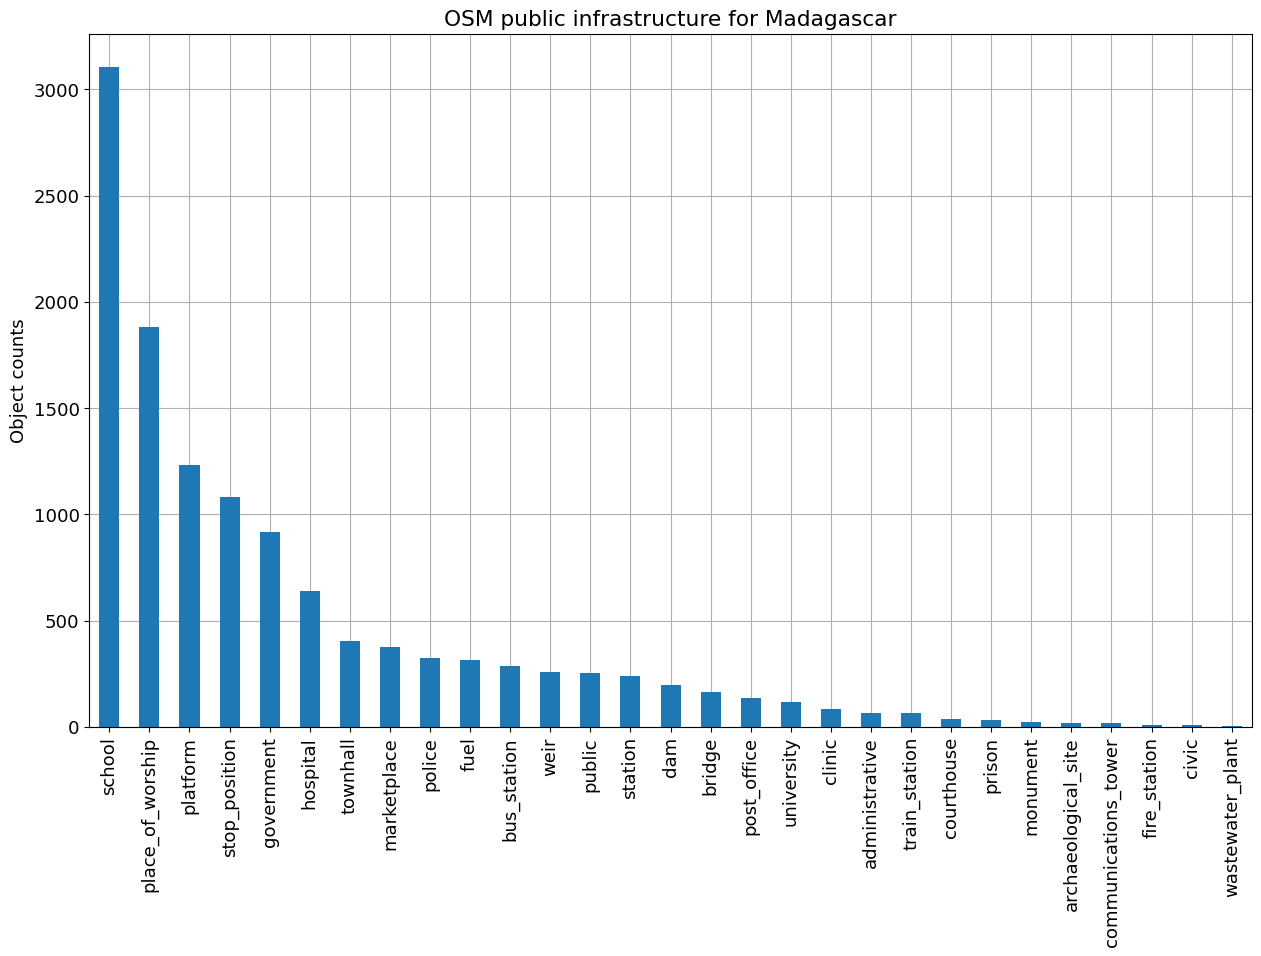

In [44]:
fig, ax = plt.subplots(figsize=(15, 9))
plt.rcParams['font.size'] = 13
pd.DataFrame(gdf_centroid['value'].value_counts()).plot(kind='bar', ax=ax, zorder=2, legend=False)
ax.set_xlabel('')
ax.set_ylabel('Object counts')
ax.grid(zorder=1)
ax.set_title('OSM public infrastructure for Madagascar')

# Conclusion

This script accomplishes the following:

- **Creation of a building footprint economic exposure layer for Madagascar (vector file of polygons)**: This layer is derived by disaggregating the economic values from the GAR15 global exposure layer across building footprints obtained from Google Open Buildings.
- **Creation of a public infrastructure exposure layer for Madagascar (vector file of points)**: This layer is based on the extraction of georeferenced features from OpenStreetMap (OSM).

Additionally:

- The computational efficiency of DuckDB for processing large datasets has been evaluated.
- QuackOSM has been utilized to extract OSM features based on OSM IDs (efficiently identified using DuckDB functions) and tags. This approach has enabled the rapid generation of vector layers representing public infrastructure.
- The process of generating building footprint economic layers and public infrastructure inventories is highly replicable in other countries, as it relies solely on publicly available datasets.